In [15]:
!pip install yfinance
!pip install hmmlearn
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import seaborn as sns

In [3]:
#Part 1: Data Collection and Preprocessing

df=pd.read_csv("data_finanse.csv")

In [4]:
df = df[['Date', 'Adj Close']]
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df.set_index('Date', inplace=True)

<ipython-input-4-4ee173952059>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
<ipython-input-4-4ee173952059>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['Date'], inplace=True)


In [5]:
df['daily_return'] = df['Adj Close'].pct_change()
df.dropna(inplace=True)

# Check for missing data
missing_data = df.isnull().sum()
df.fillna(method='ffill', inplace=True)


<ipython-input-5-98d7e1c62a04>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [10]:
X = df['daily_return'].values.reshape(-1, 1)

In [11]:
# Part 2: Gaussian Hidden Markov Model

# Define the number of hidden states
n_hidden_states = 2

model = GaussianHMM(n_components=n_hidden_states, covariance_type="diag", n_iter=1000)
model.fit(X)
hidden_states = model.predict(X)
df['hidden_state'] = hidden_states

In [12]:
# Extract mean and variance for each hidden state
means = model.means_
variances = np.sqrt(model.covars_)

for i in range(n_hidden_states):
    print(f"Hidden State {i}")
    print(f"Mean: {means[i][0]:.5f}")
    variance_value = variances[i][0].item()
    print(f"Variance: {variance_value:.5f}\n")


Hidden State 0
Mean: 0.00188
Variance: 0.01313

Hidden State 1
Mean: 0.00538
Variance: 0.05225



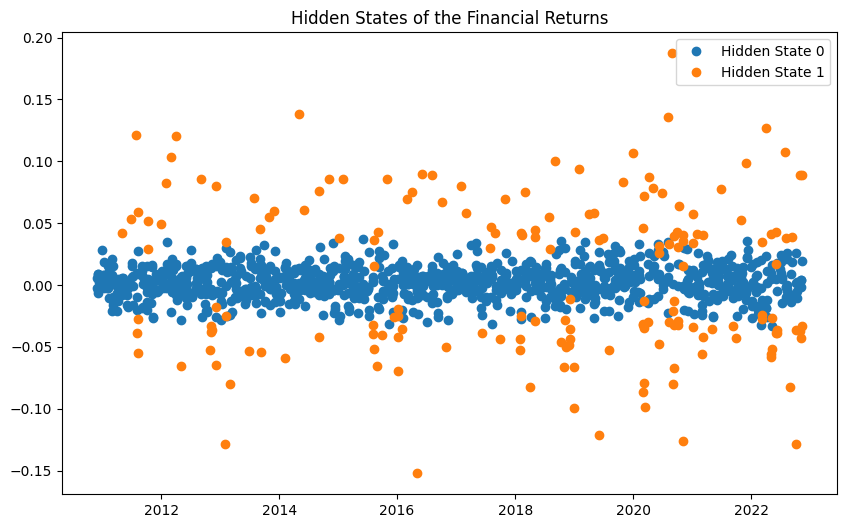

In [13]:
plt.figure(figsize=(10, 6))

for i in range(n_hidden_states):
    state = (hidden_states == i)
    plt.plot(df.index[state], df['daily_return'][state], 'o', label=f"Hidden State {i}")

plt.title('Hidden States of the Financial Returns')
plt.legend()
plt.show()

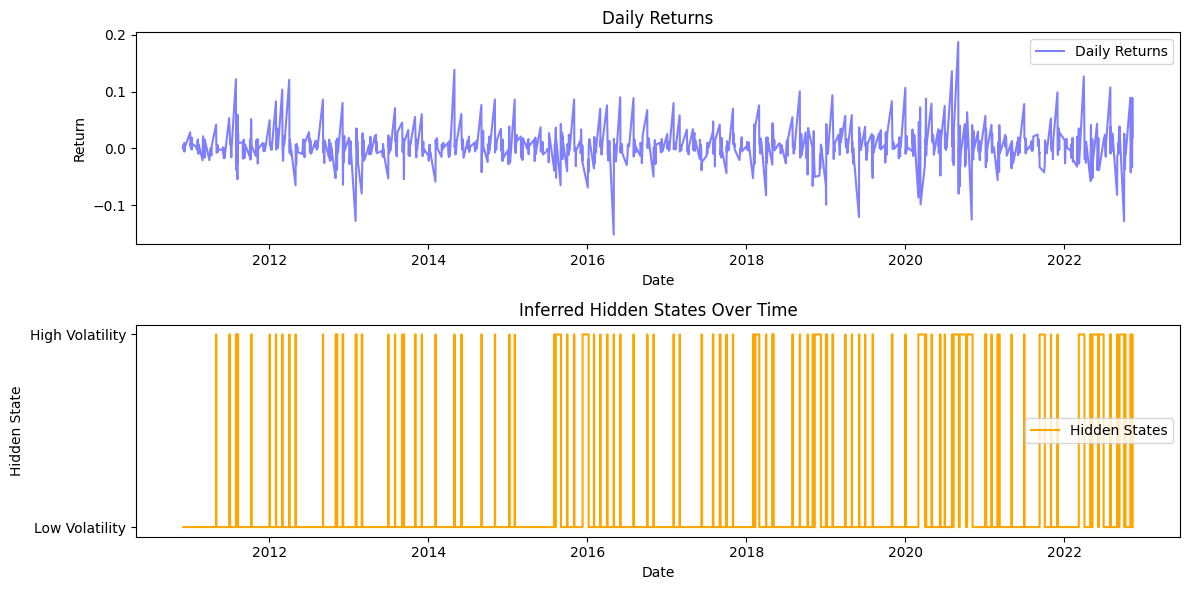

In [14]:
# Part 3: Interpretation and Inference

plt.figure(figsize=(12, 6))

# Plot daily returns
plt.subplot(2, 1, 1)
plt.plot(df.index, df['daily_return'], label='Daily Returns', color='blue', alpha=0.5)
plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()

# Plot inferred hidden states
plt.subplot(2, 1, 2)
plt.plot(df.index, df['hidden_state'], label='Hidden States', color='orange', drawstyle='steps-post')
plt.title('Inferred Hidden States Over Time')
plt.xlabel('Date')
plt.ylabel('Hidden State')
plt.yticks([0, 1], ['Low Volatility', 'High Volatility'])  # Customize labels based on interpretation
plt.legend()

plt.tight_layout()
plt.show()

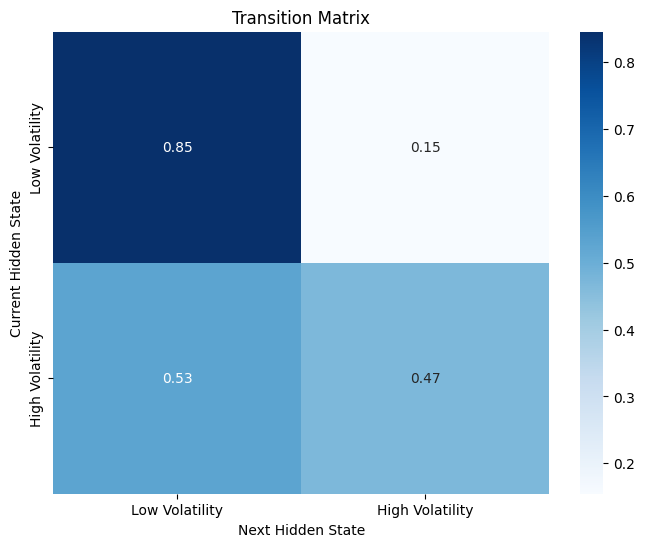

In [16]:
transition_matrix = model.transmat_

# Create a heatmap to visualize the transition matrix
plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, cmap='Blues', xticklabels=['Low Volatility', 'High Volatility'],
            yticklabels=['Low Volatility', 'High Volatility'])
plt.title('Transition Matrix')
plt.xlabel('Next Hidden State')
plt.ylabel('Current Hidden State')
plt.show()

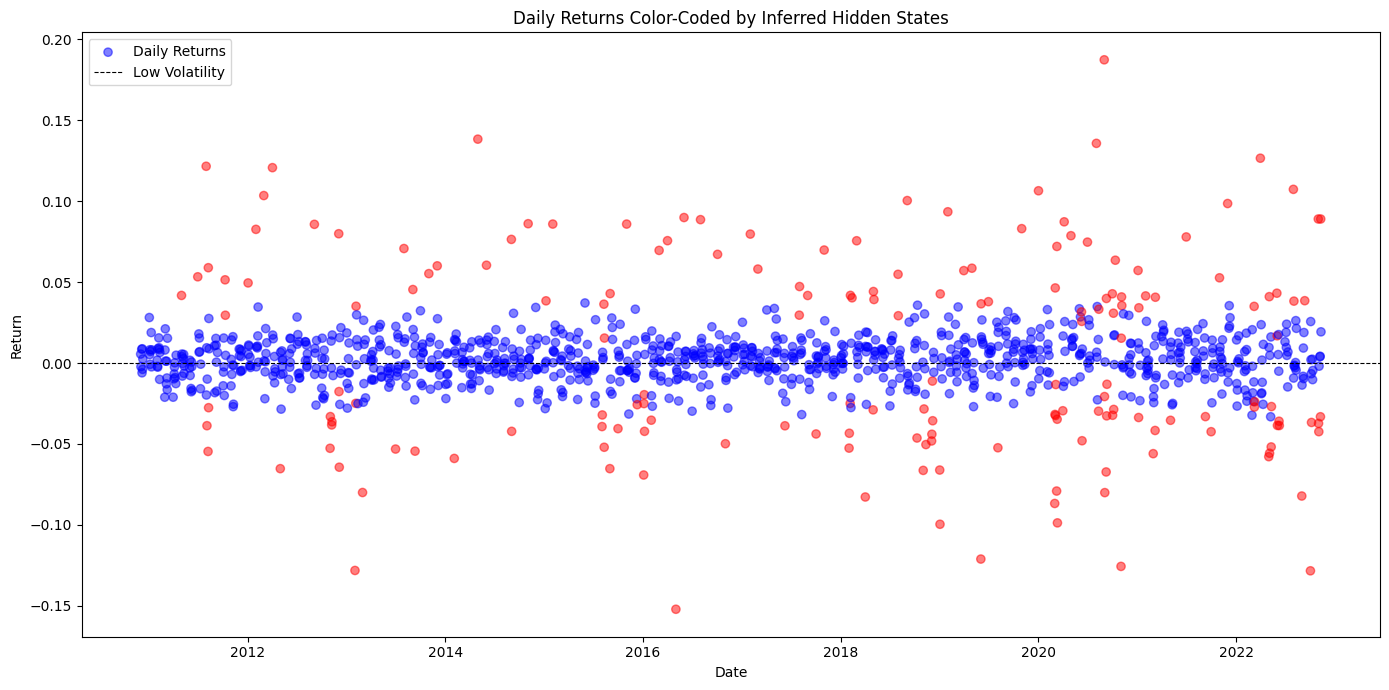

In [17]:
# Part 4: Evaluation and Visualization

plt.figure(figsize=(14, 7))

# Set colors for each hidden state
colors = ['blue' if state == 0 else 'red' for state in df['hidden_state']]

# Plot daily returns with color coding
plt.scatter(df.index, df['daily_return'], c=colors, alpha=0.5, label='Daily Returns')
plt.title('Daily Returns Color-Coded by Inferred Hidden States')
plt.xlabel('Date')
plt.ylabel('Return')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at 0 for reference
plt.legend(['Daily Returns', 'Low Volatility', 'High Volatility'], loc='upper left')

plt.tight_layout()
plt.show()